In [2]:
# READ DATA FROM CSV FILES IN StockOptions directory 
path = '../StockOptions/data/'
import pandas as pd 
import numpy as np 
import datetime as dt
from glob import glob
from tqdm import tqdm
from datafunctions import *
from scipy import stats, signal

STOCKS = [str(x).split('/')[3] for x in glob('../StockOptions/data/*')]



In [5]:
lod = {i:load_data(i,100, include_expired= False).fillna(0) for i in tqdm(STOCKS)}

100%|██████████| 123/123 [01:39<00:00,  1.23it/s]


In the last 100 days, $SPY saw an average put Lastprice of 50% exceding average call Lastprice by 0% (5 day moving average)

#OptionsTrading


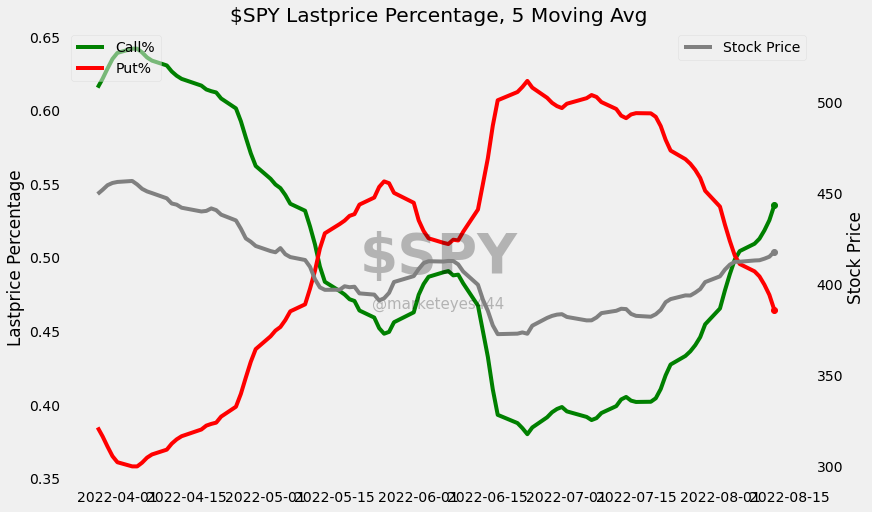

In [6]:
# Call Put Percentages 
def call_put_pct(symb, n=30, ma = 0, col = 'volume'):
    """ Plot the call and put percentages over n day period. If no covereage then max days loaded """

    import pandas as pd
    df = lod[symb].reset_index().copy()
    df['gatherDate'] = pd.to_datetime(df.gatherDate,format='%Y-%m-%d')
    casted_df = df.groupby(['gatherDate','type','stk_price'])[col].sum().reset_index()
    newdf = cast0(casted_df,'type',col)
    newdf['total'] = newdf.Call + newdf.Put
    newdf['Call'] = newdf['Call']/newdf['total']
    newdf['Put'] = newdf['Put']/newdf['total']
    del newdf['total']
    import numpy as np
    avg_call = np.mean(newdf['Call'])
    avg_put = np.mean(newdf['Put'])

    # print some text about the plot 
    if avg_call > avg_put:
        if (avg_call-avg_put)>.10:
            txt = f'In the last {len(newdf)} days, ${symb.upper()} saw an average call {str(col).capitalize()} of {avg_call:.0%} exceding average put {str(col).capitalize()} by +{avg_call-avg_put:.0%} 🔥'
        else:
            txt = f'In the last {len(newdf)} days, ${symb.upper()} saw an average call {str(col).capitalize()} of {avg_call:.0%} exceding average put {str(col).capitalize()} by {avg_call-avg_put:.0%}'
    else: 
        if (avg_put-avg_call)>.10:
            txt = f'In the last {len(newdf)} days, ${symb.upper()} saw an average put {str(col).capitalize()} of {avg_put:.0%} exceding average call {str(col).capitalize()} by +{avg_put-avg_call:.0%} 🔥'
        else:
            txt = f'In the last {len(newdf)} days, ${symb.upper()} saw an average put {str(col).capitalize()} of {avg_put:.0%} exceding average call {str(col).capitalize()} by {avg_put-avg_call:.0%}'

    #plot dataframe 
    plot_me  = newdf.copy()
    #plot_me['stk_price_scaled'] = (plot_me['stk_price'] - plot_me['stk_price'].min()) / (plot_me['stk_price'].max() - plot_me['stk_price'].min())
    if ma > 1:
        txt  += f' ({ma} day moving average)'
        plot_me = plot_me.set_index('gatherDate').rolling(ma).mean()
        plot_me = plot_me.reset_index()
    last = plot_me.iloc[-1]


    #visualize the result 
    import matplotlib.pyplot as plt

    ##### PLOT STYLE  ------
    plt.style.use('fivethirtyeight')
    #####   

    fig, ax1 = plt.subplots(figsize=(12,7),constrained_layout=True)
    ax1.plot(plot_me.gatherDate, plot_me[['Call']], color = 'green', label='Call%', alpha=1)
    ax1.plot(last.gatherDate, last[['Call']], color = 'green', marker='o')
    ax1.plot(plot_me.gatherDate, plot_me[['Put']], color = 'red', label= 'Put%', alpha = 1)
    ax1.plot(last.gatherDate, last[['Put']], color = 'red', marker='o')
    ax1.set_ylabel(str(col).capitalize() + ' Percentage')
    if ma > 1:
        ax1.set_title(f'${symb.upper()}' + f' {str(col).capitalize()} Percentage, {ma} Moving Avg')
    else:
        ax1.set_title(f'${symb.upper()}' + f' {str(col).capitalize()} Percentage')
    ax2 = ax1.twinx() 
    ax2.set_ylabel('Stock Price')
    ax2.plot(plot_me.gatherDate, plot_me[['stk_price']], label = 'Stock Price', alpha=1, color = 'grey')
    ax2.plot(last.gatherDate, last[['stk_price']],marker = 'o',  alpha=1, color = 'grey')
    ax2.set_ymargin(1)
    ax1.text(.5, .5, f'${symb.upper()}',weight = 'bold', horizontalalignment='center',verticalalignment='center',
            transform=ax1.transAxes,fontsize=55,alpha=.25)
    
    ax1.text(.5, .4, '@marketeyes444', horizontalalignment='center',verticalalignment='center',
            transform=ax1.transAxes,fontsize=15,alpha=.25)

    legend = ax1.legend(loc='upper left',fancybox=True, framealpha=0.5, )
    legend2 = ax2.legend(loc='upper right',fancybox=True, framealpha=0.5,)
    legend.get_frame()
    legend2.get_frame()

    import matplotlib.dates as mdates
    ax1.grid(False)
    ax2.grid(False)
    plt.xlim(right=ax1.get_xlim()[1]+1)
    plt.ioff()
    plt.savefig('img.jpeg')
    return txt + '\n\n#OptionsTrading'
symb = 'spy'
print(call_put_pct(symb, 180, 5, 'lastPrice'))


In [9]:
import plotly.express as px

from names import Stock_names
# store stock price in data frame so that you dont have to continuously load the same file in iteration
sp = get_price_data(STOCKS, False)
#if today not in sp.index: sp = get_price_data(stocks, True)

In [10]:
import plotly.graph_objects as go

def get_volume_profile(symbol, start_date=None, end_date=None, kde_factor = .10, num_samples = 500 ):
    if start_date is None:
        data = add_stock_price(symbol, sp).drop('Adj Close', axis=1).copy()
    else: 
        data = add_stock_price(symbol, sp)[start_date:end_date].drop('Adj Close', axis=1).copy()

    
    xr = np.linspace(data['Close'].min(), data['Close'].max(), num_samples)
    kde = stats.gaussian_kde(data['Close'],weights=data['Volume'],bw_method=kde_factor)
    kdy = kde(xr)
    ticks_per_sample = (xr.max()-xr.min())/num_samples
    
    kx = np.linspace(data['Close'].min(), data['Close'].max(),num_samples)
    ky = kde(xr)
    min_prom = ky.max() *.3

    # Calculate Average Trading Range 
    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data['Close'].shift())
    low_close = np.abs(data['Low'] - data['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    atr = true_range.rolling(14).sum()/14
    max_width_pips = atr.mean()
    
    min_prom = kdy.max() * 0.3
    width_range=(.01, max_width_pips*.0001 / ticks_per_sample)
    peaks, peak_props = signal.find_peaks(kdy, width=0, prominence=min_prom)
    
    
    pkx = xr[peaks]
    pky = kdy[peaks]
    fig = go.Figure()
    
    fig.add_trace(go.Histogram(name='VolumeProfiler', x=data['Close'], y=data['Volume'], nbinsx= 150, opacity=0.6,histfunc='sum',histnorm='probability density'))
    fig.add_trace(go.Scatter(name='KDE', x=xr, y=kdy, mode='lines'))
    fig.add_trace(go.Scatter(name= 'Peaks', x = pkx, y= pky, mode='markers'))


    left_base = peak_props['left_bases']
    right_base = peak_props['right_bases']
    line_x = pkx
    line_y0 = pky
    line_y1 = pky- peak_props['prominences']

    left_ips = peak_props['left_ips']
    right_ips = peak_props['right_ips']
    width_x0 = xr.min() + (left_ips * ticks_per_sample)
    width_x1 = xr.min() + (right_ips * ticks_per_sample)
    width_y = peak_props['width_heights']

    for x,y0,y1 in zip(line_x, line_y0, line_y1):
        fig.add_shape(type='line',xref='x',yref='y',x0=x, y0=y0, x1=x, y1=y1,line=dict(color='black',width=2,))
    
    for x0, x1, y in zip(width_x0, width_x1, width_y):
        fig.add_shape(type='line',xref='x', yref='y',x0=x0, y0=y, x1=x1, y1=y,line=dict(color='black',width=2,))

    return fig


# get ohlcv for a prticular symbol 
def add_stock_price(stock, sp):
    """Slice dataframe to get stock price for a particular symbol"""
    out = sp.xs(key = stock.upper(), axis = 1, level = 'Stock_name', drop_level=True)
    out.columns.names = ['']
    out.columns = out.columns.get_level_values(0)
    return out



In [34]:
np.arange(0, 1, .01).shape

(100,)

In [13]:
from plotly.subplots import make_subplots
def dual_plot(dropdown_value):
    df = add_stock_price(dropdown_value, sp)
    gvp = get_volume_profile(dropdown_value)
    
    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add traces
    fig.add_trace(
        go.Scatter(x=df.index, y=df.Close, name="Close Price"),
        secondary_y=False,
    )

    fig.add_trace(
        go.Scatter(x=df.index, y=df.Close.pct_change(), name="Returns"),
        secondary_y=True,
    )

    # Add figure title
    fig.update_layout(
        title_text=f'{dropdown_value} Close Price'
    )

    # Set x-axis title
    fig.update_xaxes(title_text="<b>Date</b>")

    # Set y-axes titles
    fig.update_yaxes(title_text="<b>Stock Price</b>", secondary_y=False)
    fig.update_yaxes(title_text="<b>Volume</b>", secondary_y=True)

    return fig 

In [14]:
dual_plot('spy')

In [15]:
def Stock_returns(stock):
    df = add_stock_price(stock, sp)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df.index, y=df.Close.pct_change(), name="Returns"))
    fig.update_layout(title_text=f'{stock} Returns')
    fig.update_xaxes(title_text="<b>Date</b>")
    fig.update_yaxes(title_text="<b>Returns</b>")
    return fig
    

In [23]:
def candle_stick(stock):
    df = add_stock_price(stock, sp)
    fig = go.Figure()
    fig.add_trace(go.Candlestick(x=df.index, open=df.Open, high=df.High, low=df.Low, close=df.Close))
    fig.update_layout(xaxis_rangeslider_visible=False)
    fig.update_layout(title_text=f'${stock.upper()} Stock Price')
    fig.update_xaxes(title_text="<b>Date</b>")
    fig.update_yaxes(title_text="<b>Price</b>")
    return fig

In [24]:
candle_stick('spy')